# Imports
import required libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.callbacks as callbacks
%matplotlib inline

In [2]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Dataset
import dataset path and label csv file. Read csv file using pandas library read_csv function. 
Visualize csv file data for first 35 readings.

In [3]:
DATASET_PATH = "../input/bee-vs-wasp/kaggle_bee_vs_wasp"

label_csv = os.path.join(DATASET_PATH, 'labels.csv')

In [4]:
label_df = pd.read_csv(label_csv)
label_df.head(35)

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee
5,6,bee1\10130729734_f68738333e_w.jpg,1,0,0,0,1,0,0,bee
6,7,bee1\10166485783_9cd6706c72_n.jpg,1,0,0,0,1,0,0,bee
7,8,bee1\10179824_84803290ac_m.jpg,1,0,0,0,1,0,0,bee
8,9,bee1\10197482094_0176d1bacb_n.jpg,1,0,0,0,1,0,0,bee
9,10,bee1\10242298546_aac12f5223_n.jpg,1,0,0,0,1,0,0,bee


# Understanding Dataset distribution
create dataset distribution based on label.csv file. All the input images are distributed among training data, validation data and testing datasets. Images are distributed among 4 different classes namely bee, wasp, insect, other (non insect). 

In [5]:
def dataset_distribution(row):
  if row['is_validation'] == 0 and row['is_final_validation'] == 0:
    return 'train'
  elif row['is_validation'] == 1:
    return 'validation'
  else:
    return 'test'
  
label_df['type'] = label_df.apply(dataset_distribution, axis = 1)
print('Number of images in each set:')
label_df['type'].value_counts()


Number of images in each set:


train         7939
test          1763
validation    1719
Name: type, dtype: int64

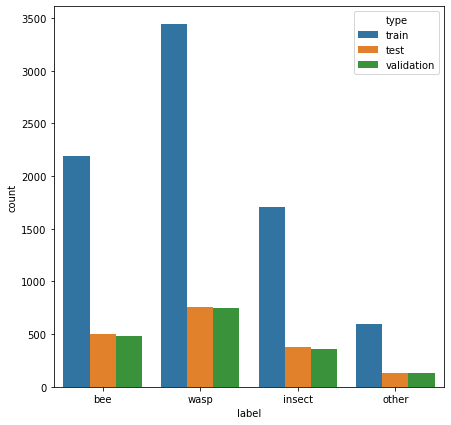

In [6]:
plt.figure(figsize = (7,7))
sb.countplot(x = 'label', hue='type', data= label_df)
plt.show()

In [7]:
label_df['path'] = label_df['path'].str.replace('\\', os.sep)
label_df['path'].head()

0    bee1/10007154554_026417cfd0_n.jpg
1    bee1/10024864894_6dc54d4b34_n.jpg
2    bee1/10092043833_7306dfd1f0_n.jpg
3     bee1/1011948979_fc3637e779_w.jpg
4    bee1/10128235063_dca17db76c_n.jpg
Name: path, dtype: object

# Setting up pipelines and data preprocessing
setup training, validation and testing pipelines. Convert all images to image size of (224,224). Use ImageDataGenerator function of keras.preprocessing for preprocessing images to pipeline.

In [8]:
train_df = label_df[label_df['type'] == 'train']
validation_df = label_df[label_df['type'] == 'validation']
test_df = label_df[label_df['type'] == 'test']

In [9]:
image_size = (224,224)
BATCH_SIZE = 32
EPOCHS = 15
SEED = 42

In [10]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_set = datagen.flow_from_dataframe(train_df, 
                                            directory=DATASET_PATH, 
                                            x_col="path", 
                                            y_col="label",
                                            target_size=image_size,
                                            seed = 42
                                       )


validation_set = datagen.flow_from_dataframe(validation_df, 
                                            directory=DATASET_PATH, 
                                            x_col="path", 
                                            y_col="label",
                                            target_size=image_size,
                                            seed = 42
                                           )

test_set = datagen.flow_from_dataframe(test_df, 
                                      directory=DATASET_PATH, 
                                      x_col="path", 
                                      y_col="label",
                                      target_size=image_size,
                                      seed = 42
                                      )

Found 7939 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.


In [11]:
number_of_classes = len(label_df['label'].unique())
print("number_of_classes : ",number_of_classes)

number_of_classes :  4


# Setup VGG19 model with imageNet weights
Let's setup VGG19 CNN based model for object classification task. This model is pretrained with imageNet weights. 
ImageNet is a big dataset with 1.4M images and 1000 classes of web images. Let's check the performance of this model on bee classification task. 

In [12]:
vgg19 = keras.applications.VGG19(include_top=False,weights="imagenet", input_shape=(224,224, 3),classifier_activation="softmax")

80142336/80134624 [==============================] - 1s 0us/step


# adding last layer
add last layer to vgg19 model with "softmax" activation function. Use Adam optimizer with learning rate set to 0.0001. Train the model for 50 epochs and verify the loss and accuracy after each epoch.

In [13]:
from tensorflow.keras.initializers import RandomNormal, Constant

model = models.Sequential([
    vgg19,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(number_of_classes,activation="softmax")
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

history = model.fit(train_set, 
          validation_data=validation_set, 
          batch_size=32,
          epochs=50,
         )

Epoch 1/50
249/249 [==============================] - 134s 514ms/step - loss: 0.4723 - accuracy: 0.5152 - val_loss: 0.2962 - val_accuracy: 0.7225
Epoch 2/50
249/249 [==============================] - 70s 282ms/step - loss: 0.3023 - accuracy: 0.7331 - val_loss: 0.2509 - val_accuracy: 0.7917
Epoch 3/50
249/249 [==============================] - 70s 281ms/step - loss: 0.2319 - accuracy: 0.8153 - val_loss: 0.1690 - val_accuracy: 0.8674
Epoch 4/50
249/249 [==============================] - 70s 279ms/step - loss: 0.1715 - accuracy: 0.8694 - val_loss: 0.1488 - val_accuracy: 0.8918
Epoch 5/50
249/249 [==============================] - 70s 279ms/step - loss: 0.1505 - accuracy: 0.8893 - val_loss: 0.1480 - val_accuracy: 0.8924
Epoch 6/50
249/249 [==============================] - 70s 279ms/step - loss: 0.1188 - accuracy: 0.9142 - val_loss: 0.1331 - val_accuracy: 0.9040
Epoch 7/50
249/249 [==============================] - 70s 279ms/step - loss: 0.1004 - accuracy: 0.9278 - val_loss: 0.1464 - val_a

# Plot loss vs Accuracy
plot trainig loss vs accuracy curve. Compare this curves with validation loss and validation accuracy curves.

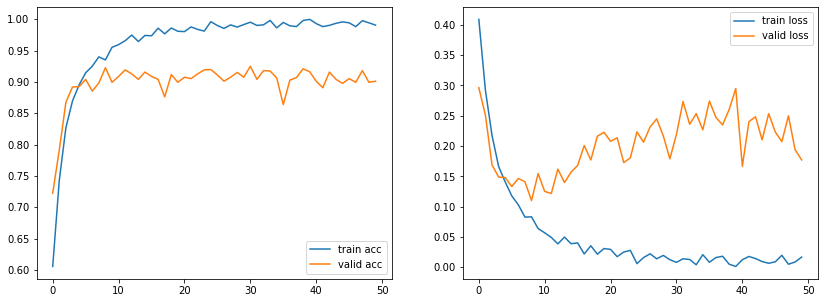

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend()

plt.show()

# Evaluating model on test set
Evaluate the model performance on test set. Check the testing accuracy.

In [15]:
test_loss, test_acc = model.evaluate(test_set, verbose=2)
print("Test accuracy:", test_acc)

56/56 - 19s - loss: 0.1699 - accuracy: 0.8883
Test accuracy: 0.8882586359977722


# Visualize classification on sample test images

Define function load image to load images and process it to fit the model requirement. Pass sample images to this function and get the output for model.predict_classes function. 

model.predict_classes function will give us the most likely class of the image. 

In [16]:
from keras.preprocessing import image
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224,224))
    imgplot = plt.imshow(img)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

NameError: name 'np' is not defined

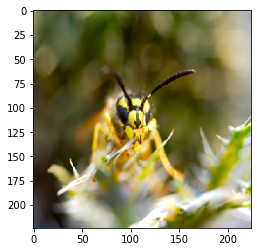

In [17]:
import numpy as np
# image path
img_path = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/1032128732_50dade4f6f_n.jpg'

# load a single image
new_image = load_image(img_path)

# check prediction
pred = model.predict_classes(new_image)
print(pred[0])
    
    
if pred[0] == 0:
  print("Bee")
elif pred[0] == 1:
  print("insect")
elif pred[0] == 2:
  print("other non insect")
elif pred[0] == 3:
  print("Wasp")

In [ ]:


# image path
img_path = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/bee1/10024864894_6dc54d4b34_n.jpg'    # dog
#img_path = '/media/data/dogscats/test1/19.jpg'      # cat

# load a single image
new_image = load_image(img_path)

# check prediction
pred = model.predict_classes(new_image)
print(pred[0])
    
    
if pred[0] == 0:
  print("Bee")
elif pred[0] == 1:
  print("insect")
elif pred[0] == 2:
  print("other non insect")
elif pred[0] == 3:
  print("Wasp")